# 作业三：多分类和神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1 多分类
### 1.1 数据处理

In [2]:
data = loadmat('ex3data1.mat')
X = data['X']
X = np.insert(X,0,1,axis=1)
y = data['y']
print(X.shape,y.shape)

(5000, 401) (5000, 1)


<function matplotlib.pyplot.show(*args, **kw)>

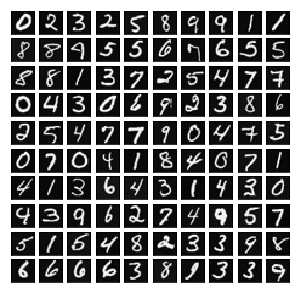

In [3]:
def plot_100_image(X):
    
    num = np.random.randint(1,5000,100)
    image = X[num,:]
    
    fig,ax = plt.subplots(nrows=10,ncols=10,sharey=True,sharex=True,figsize=(5,5))
    
    for i in range(10):
        for j in range(10):
            ax[i,j].matshow(image[10*i+j,1:].reshape(20,20).T,cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  

plot_100_image(X)
plt.show

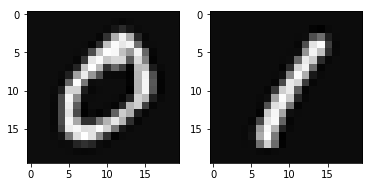

In [4]:
#当label=10时，代表手写数字0
label_10_index = np.where(y==10)[0][0]
label_1_index = np.where(y==1)[0][0]
plt.subplot(121)
plt.imshow(X[label_10_index,1:].reshape(20,20).T,cmap='gray')
plt.subplot(122)
plt.imshow(X[label_1_index,1:].reshape(20,20).T,cmap='gray')
plt.show()

In [5]:

#y_new[0]中样本数字为0的值为1,y_new[1]中样本数字为1的值为1
#依次类推，生成y_new(10,5000)
y = data['y'].flatten()
y_new = np.zeros((5000,10))
for k in range(1,10):
    y_new[:,k] = (y==k).astype(int)
y_new[:,0] = (y==10).astype(int)
y = y_new
print(y.shape)

(5000, 10)


### 1.2 计算代价函数及梯度

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def computeRegularizedCost(theta,X,y,lam=0.):
    m = X.shape[0] #5000
    term1 = np.sum(y*np.log(sigmoid(np.dot(X,theta))))/m 
    term2 = np.sum((1.0-y)*np.log(1.0-sigmoid(np.dot(X,theta))))/m
    termreg = np.sum(theta[1:]*theta[1:])*lam/(2*m)
    return -term1-term2+termreg

def computeRegularizedGradient(theta,X,y,lam=0.):
    m = X.shape[0]
    error = sigmoid(np.dot(X,theta))-y#5000,
    termreg = (lam/m)*theta[1:] # 400,
    grad = np.dot(X.T,error)/m #401,
    grad[1:] = grad[1:]+termreg
    return grad

theta = np.zeros((X.shape[1]))
print(computeRegularizedCost(theta,X,y[:,0],lam=1))
print(computeRegularizedGradient(theta,X,y[:,0],lam=1).shape)

0.6931471805599453
(401,)


In [7]:
from scipy.optimize import minimize
def optimizeTheta(X,y,lam=1):
    theta = np.zeros((X.shape[1]))
    
    result = minimize(fun=computeRegularizedCost, x0=theta, args=(X, y, lam),
                      jac=computeRegularizedGradient)
    return result.x

def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

theta0 = optimizeTheta(X, y[:,0])
y_pred = predict(X, theta0)
print(theta0.shape)
print('Accuracy='+str(np.mean(y[:,0] == y_pred)))

(401,)
Accuracy=0.9974


### 1.3 训练所有模型

In [8]:
final_theta = []
for k in range(10):
    final_theta.append(optimizeTheta(X,y[:,k],lam=1))
    y_pred=predict(X, final_theta[k])
    print('Optimizing for handwritten number {:d}.Accuracy={:3f}'.format(k,np.mean(y[:,k] == y_pred)))
final_theta = np.array(final_theta) 
print(final_theta.shape)

Optimizing for handwritten number 0.Accuracy=0.997400
Optimizing for handwritten number 1.Accuracy=0.993400
Optimizing for handwritten number 2.Accuracy=0.981000
Optimizing for handwritten number 3.Accuracy=0.982000
Optimizing for handwritten number 4.Accuracy=0.986600
Optimizing for handwritten number 5.Accuracy=0.979600
Optimizing for handwritten number 6.Accuracy=0.992600
Optimizing for handwritten number 7.Accuracy=0.988400
Optimizing for handwritten number 8.Accuracy=0.969200
Optimizing for handwritten number 9.Accuracy=0.975200
(10, 401)


In [9]:
# 计算最终的准确度
## 这里的预测方法跟第二部分不同
## 原因在于两者生成y(5000,10)的方法不同
y_prob = sigmoid(np.dot(X,final_theta.T))
y_pred = np.argmax(y_prob,axis=1)##这里argmax结果为0时，预测结果就为0；1->1;2->2...
y_raw = data['y']
y_raw[y_raw==10] = 0
print(np.mean(y_raw.flatten()==y_pred))

0.9446


## 2 神经网络
### 2.1 导入预训练模型

In [10]:
weights = loadmat('ex3weights.mat')
Theta1,Theta2 = weights['Theta1'] , weights['Theta2']
print(Theta1.shape,Theta2.shape)

(25, 401) (10, 26)


### 2.2 前向传播

In [11]:
def propagateForward(X,Theta):
    features = X
    for i in range(len(Theta)):
        theta = Theta[i]
        y = sigmoid(np.dot(features,theta.T))
        if i < len(Theta)-1:
            y = np.insert(y,0,1,axis=1)
        features = y
    return features
        
y_prob = propagateForward(X,[Theta1,Theta2])
##注意此处的预测方法与第一部分中的不同
##在训练时，生成y(5000,10)时的方法不同
y_pred = np.argmax(y_prob,axis=1) # 若某样本argmax后为0，则实际预测结果为1;1->2;...;9->0
y_raw = data['y']
y_pred = y_pred+1
y_pred[y_pred==10] =0
print(np.mean(y_raw.flatten()==y_pred))

0.9752
